# Zonal Statistics - continuous values

In [1]:
import glob, os
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterstats
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from pathlib import Path
import datetime
from IPython.display import display
import numpy as np

print('All libraries successfully imported!')
print(f'Rasterstats : {rasterstats.__version__}')

All libraries successfully imported!
Rasterstats : 0.14.0


In [2]:
import warnings
warnings.filterwarnings("ignore")

print("BE CAREFULL warning are masked !!")

BE CAREFULL warning are masked !!


## Set parameters

Choose statistics :
- min
- max
- mean

In [4]:

nodata_val = -10000

start = '20200101'
end   = '20200601'

### Date
The date must be in each image filename. `begin_date` is the first position of the date

E.g. : "SITE_3_**2**0181108_NDVI.tif" --> **begin_date = 8**

In [3]:
format     = '%Y%m%d' # format : YYYYMMDD
begin_date = 8

## Set directory

In [29]:

# Directory for all work files
work_path = f'/export/miro/students/bnorgaard/Backup_training_data/'


# Rasters files directory
raster_file_list = sorted(glob.glob(f'{work_path}images/Subset_S2A_MSIL2A_20200407T104021_N0214_R008_T31UFS_20200407T113125_resampled_BandMath.data/*.img'))

raster_file_list = sorted(glob.glob(f'{work_path}images/Subset_S2A_MSIL2A_20201106T105241_N0214_R051_T31UFS_20201106T134121_resampled_BandMath.data/*.img'))


print(raster_file_list)
# Vector file
vector_file  = f'{work_path}shp/invariant_shp/invariant_surfaces.shp'

# Zonal statistics output
zonal_stat_path = f'{work_path}ZONAL_STATS/'


Path(zonal_stat_path).mkdir(parents=True, exist_ok=True)

['/export/miro/students/bnorgaard/Backup_training_data/images/Subset_S2A_MSIL2A_20201106T105241_N0214_R051_T31UFS_20201106T134121_resampled_BandMath.data/B2.img', '/export/miro/students/bnorgaard/Backup_training_data/images/Subset_S2A_MSIL2A_20201106T105241_N0214_R051_T31UFS_20201106T134121_resampled_BandMath.data/B3.img', '/export/miro/students/bnorgaard/Backup_training_data/images/Subset_S2A_MSIL2A_20201106T105241_N0214_R051_T31UFS_20201106T134121_resampled_BandMath.data/B4.img', '/export/miro/students/bnorgaard/Backup_training_data/images/Subset_S2A_MSIL2A_20201106T105241_N0214_R051_T31UFS_20201106T134121_resampled_BandMath.data/B8.img', '/export/miro/students/bnorgaard/Backup_training_data/images/Subset_S2A_MSIL2A_20201106T105241_N0214_R051_T31UFS_20201106T134121_resampled_BandMath.data/lai.img']


## Check if raster and vector are projected to the same CRS

In [14]:
gdf = gpd.read_file(vector_file)
src = rasterio.open(raster_file_list[0], "r")

crs_vector = str(gdf.crs).split(":",1)[1]
crs_raster = str(src.crs).split(":",1)[1]

if crs_vector == crs_raster:
    print(f'CRS are the same : EPSG:{crs_vector} = EPSG:{crs_raster}')
else:
    print('We must reproject vector file')

    gdf = gdf.to_crs(epsg=crs_raster)

We must reproject vector file


**Check if raster and vector file are intersecting**

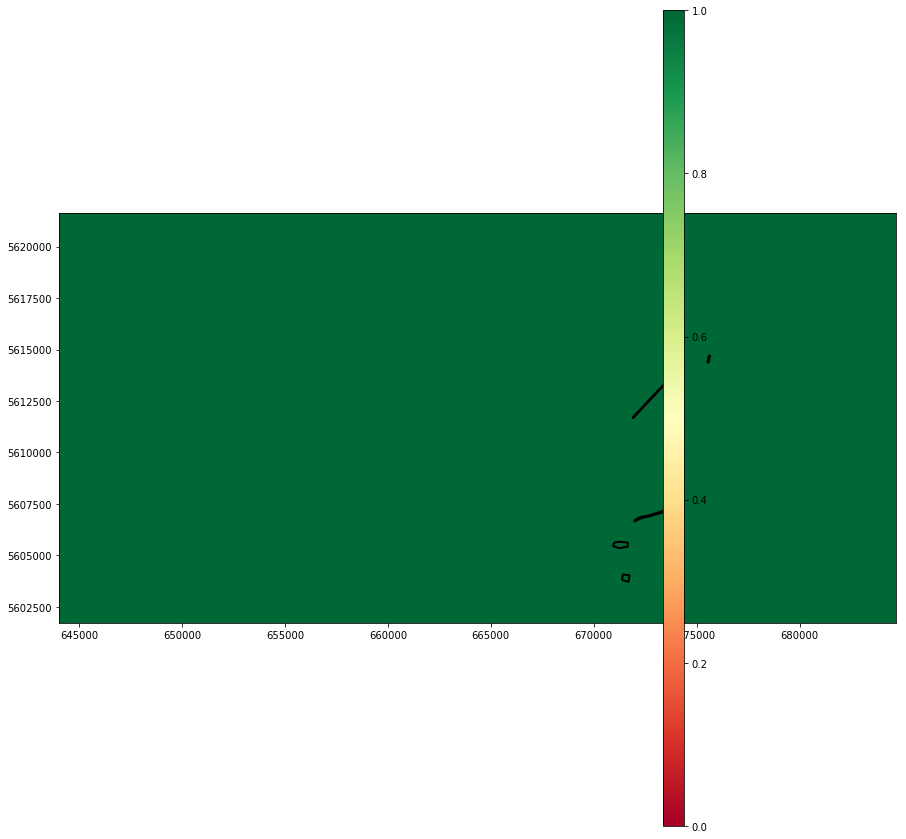

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

# Plot vector
gdf.plot(facecolor='none', edgecolor='black', linewidth = 2, ax=ax)

# Plot image
color_map = plt.cm.get_cmap("RdYlGn")
reversed_color_map = color_map.reversed()

src = rasterio.open(raster_file_list[2], "r")
im_rio = rasterio.plot.show(src, cmap=color_map, vmin=0, vmax=1, ax=ax)
im_rio = im_rio.get_images()[0]

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im_rio, ax=ax, cax=cax)


plt.box(False)

In [17]:
gdf["id"] = gdf.index

display(gdf)

,id,TYPE,geometry
0,0,quarry,"POLYGON ((670994.030 5605621.100, 671284.291 5..."
1,1,water,"POLYGON ((673420.000 5607178.563, 673448.220 5..."
2,2,warehouse roof,"POLYGON ((675595.072 5614716.763, 675651.630 5..."
3,3,pine trees,"POLYGON ((671377.412 5603807.503, 671411.010 5..."
4,4,airport_track,"POLYGON ((671884.400 5611693.025, 673419.840 5..."


## Get date of each image

In [30]:
dict_list = []

for im in raster_file_list:
            
        date_str = 'B' + os.path.basename(im)[1:2]
        
        print(date_str)

        dict_list.append({'date': date_str,
                            'im_path': im})

im_date_path_df = pd.DataFrame.from_dict(dict_list).sort_values('date')

display(im_date_path_df)

B2
B3
B4
B8
Ba


,date,im_path
0,B2,/export/miro/students/bnorgaard/Backup_trainin...
1,B3,/export/miro/students/bnorgaard/Backup_trainin...
2,B4,/export/miro/students/bnorgaard/Backup_trainin...
3,B8,/export/miro/students/bnorgaard/Backup_trainin...
4,Ba,/export/miro/students/bnorgaard/Backup_trainin...


### Select images inside a period

## Compute zonal statistics

In [12]:
def mean_div_std(x):

    mean = np.mean(x)
    std  = np.std(x)

    result = mean / std

    return result

In [33]:
df_list = []
date_list = []

for i, row in im_date_path_df.iterrows():
    im_file    = row['im_path']
    date  = row['date']
    
    # Open GeoTIFF file
    src = rasterio.open(im_file, 'r')
    im_arr = src.read(1)
    
    # Change NaN by "nodata_val"
    im_arr = np.nan_to_num(im_arr, nan=nodata_val)

    # Get transform from profile (metadata)
    profile = src.profile
    transform = profile['transform']
    
    src.close()

    df = pd.DataFrame(zonal_stats(gdf,
                                  im_arr,
                                  affine=transform,
                                  stats=['mean'],
                                  nodata=nodata_val))
    
    df = df.rename(columns={'mean': f'mean__{date}'})
    
    df_list.append(df)
    

dfs = pd.concat(df_list, axis=1).divide(10000)

display(dfs)
display(gdf)


,mean__B2,mean__B3,mean__B4,mean__B8,mean__Ba
0,0.024499,0.034038,0.037920,0.058099,0.000037
1,0.011120,0.024980,0.020095,0.013518,0.000025
2,0.265435,0.294877,0.316177,0.335580,0.000018
3,0.005833,0.028233,0.029132,0.190367,0.000128
4,0.058782,0.071210,0.079812,0.117712,0.000005


,id,TYPE,geometry
0,0,quarry,"POLYGON ((670994.030 5605621.100, 671284.291 5..."
1,1,water,"POLYGON ((673420.000 5607178.563, 673448.220 5..."
2,2,warehouse roof,"POLYGON ((675595.072 5614716.763, 675651.630 5..."
3,3,pine trees,"POLYGON ((671377.412 5603807.503, 671411.010 5..."
4,4,airport_track,"POLYGON ((671884.400 5611693.025, 673419.840 5..."
